# Homework #9:
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 10/25/2019|
|Updated | 10/25/2019|

## 15.5 Local Optimization

### 1. Monte Carlo Optimization
We wish to find the minimum value of the following 2D function:

$$ f(x, y) = \frac{x^2}{2} + \frac{y^2}{4} \tag{1}$$

We can first attempt this using the Monte Carlo method. Specifically, we will generate $N$ random numbers ($N_x$ and $N_y$, within some predetermined domain of $x$ and $y$) that we then use to evaluate $f(x, y)$. With each subsequent evaluation, we store the lowest value of $f$ encountered thus far. Theoretically, by the end of the series of evaluations, the lowest evaluation of $f$ should be close to the true minimum. The larger the value of $N$ the closer we expect to be to the true minimum.

First let's plot the function to get an idea of where the minimum should be.

In [63]:
import numpy as np

x_min, x_max = -2, 2  # range of x
y_min, y_max = -2, 2  # range of y

def f(x, y):
    return 1/2*x**2 + 1/4*y**2

nx = np.linspace(x_min,x_max,100)
ny = np.linspace(y_min,y_max,100)
x,y = np.meshgrid(nx,ny)
z = f(x, y)

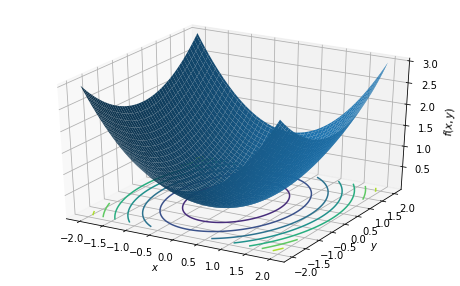

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure(figsize=[8,5])
ax = fig.gca(projection='3d', aspect="auto")
ax.plot_surface(x,y,z, alpha=1.0)
cset = ax.contour(x,y,z, zdir='z', offset=0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$')
plt.show()

Since this is a 2D projection of a 3D plot, a rotating animation may help visualize the function.

In [29]:
# init function plots BG of each frame
def init():
    return fig,

# animation function called sequentially each frame
def animate(t):
    ax.view_init(elev=30, azim=t)
    return fig,

# call animator
anim = animation.FuncAnimation(fig, animate, init_func=init,
    frames=360, interval=16, blit=True, repeat=True)

HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

Now let's try to find the minimum with the Monte Carlo method.

In [36]:
# Monte Carlo Minimize
from random import random

def MCmin(N, f, x_start, x_end, y_start, y_end):
    """
    Determine and return the minimum of a 2D function 'f', using
    the Monte Carlo method, by generating N random points in the
    bounded region (x_start, x_end, y_start, y_end).
    """
    x_dom = x_end - x_start  # x domain of search
    y_dom = y_end - y_start  # y domain of search
    # start off with a pair of random coordinates
    min_x, min_y = x_dom*random() + x_min, y_dom*random() + y_min
    
    for i in range(N):
        # generate new random pair of coordinates
        x = x_dom*random() + x_min
        y = y_dom*random() + y_min        
        if f(x, y) < f(min_x, min_y):
            min_x, min_y = x, y
    return min_x, min_y, f(min_x, min_y)

In [43]:
import time

timer_start = time.perf_counter() # start of timer
x, y, min_val = MCmin(int(1e7), f, -2, 2, -2, 2)
timer_end = time.perf_counter() # end timer
time = timer_end - timer_start

print("Minimum found:")
print("x =", x)
print("y =", y)
print("f(x, y) =", min_val)
print("Time to calculate:", time, "seconds")

Minimum found:
x = 0.00040156253216672155
y = -0.0005123824103234753
f(x, y) = 1.462601672222982e-07
Time to calculate: 6.675035900028888 seconds


#### Error Analysis
Analytically, we know the minimum is $f(0, 0) = 0$, so our Monte Carlo method got us pretty close with an $N$ of 10 million. But let's compare the accuracy with different values of $N$, e.g., 10, 100, 1000, 10000. Since we know the true minimum is at (0, 0), we can simply look at a top-down view of the $x$-$y$ plane to see where the series of runs found the minimum to be as a function of $N$.

In [123]:
def MCminStats(N, f, x_start, x_end, y_start, y_end, runs, plot):
    """
    Repeatedly find the minimum using the Monte Carlo method, MCmin(),
    for as many "runs," compile the dataset and return its variance.
    """
    
    data = np.zeros((runs, 3))
    
    for i in range(runs):
        data[i:] = MCmin(N, f, x_start, x_end, y_start, y_end)
        
    title = "Statistics for " + str(runs) + " runs with $N =$" + str(N)
    
    if plot:
        x, y = np.meshgrid(nx, ny)
        z = f(x, y)
        levels = np.arange(np.min(z), np.max(z), 0.3)
        
        plt.figure(figsize=[4,4])
        plt.contour(x, y, z, levels=levels)
        plt.plot(data[:, 0], data[:, 1], ".")
        plt.title(title)
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.show()
        
        # For 3D plots
#         if plot:
#         fig = plt.figure(figsize=[8,5])
#         ax = fig.gca(projection='3d', aspect="auto")
#         ax.scatter(data[:,0], data[:,1], data[:,2], alpha=1.0)
#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.set_zlabel('f')
#         plt.show()
    
    return np.var(data[:,2])

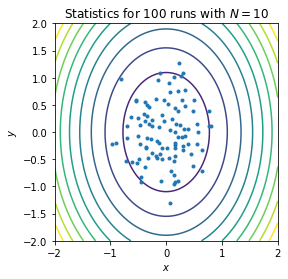

Variance: 0.014007941881976318


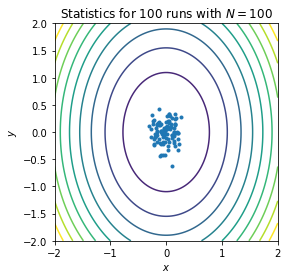

Variance: 0.0002880832647124254


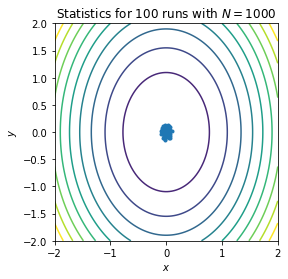

Variance: 2.3462080689631566e-06


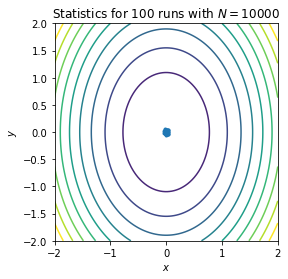

Variance: 4.9170985369431854e-08


In [124]:
runs = 100
diff_Ns = [10, 100, 1000, 10000]

for i in diff_Ns:
    print("Variance:", MCminStats(i, f, -2, 2, -2, 2, runs, True))

As we might expect, the variance of the calculated area over multiple runs decreases as $N$ increases, corresponding to an improvement in accuracy.

### 2. Gradient Descent
Now let's try finding the minimum using the _gradient descent_ method with a variable step size. We'll use the _Barzilai-Borwein method_ to vary our step size. For every subsequent step,

$$ \gamma_n = \frac{(x_n-x_{n-1})^T [\nabla f(x_n) - \nabla f(x_{n-1})]} {||\nabla f(x_n) - \nabla f(x_{n-1})||^2}, \tag{2}$$

where $\gamma$ is the step size. Thus, by descending the gradient, our next step will be

$$x_{n+1} = x_n - \gamma \nabla f(x_n), \tag{3}$$

where $f'$ is the gradient.

First we need to define a function that returns the gradient at a coordinate $(x, y)$.

In [91]:
def Gradient(f, coord, d=0.001):
    """
    Calculate and return, as an array, the gradient of 'f' at 
    the coordinate coord[x, y].
    """
    x, y = coord[0], coord[1]
    df_dx = (f(x+d, y) - f(x, y))/d
    df_dy = (f(x, y+d) - f(x, y))/d
    return np.array([df_dx, df_dy])

Next we define our gradient descent function.

In [96]:
def GradDescent(f, start_coord, N=1000):
    """
    Use the gradient descent method with a variable step size
    (Barzilai-Borwein method) to find the minimum of 'f', starting
    at start_coord[x, y], in N number of steps.
    """    
    curr_coord = start_coord
    prev_coord = None
    converged = False
    coord_hist = [] # store the coordinates at each step
    coord_hist.append(curr_coord)
    
    for i in range(N):
        df_curr = Gradient(f, curr_coord) 
        
        if prev_coord is None:
            gamma = 0.01
        else:
            df_prev = Gradient(f, prev_coord)
            dd = df_curr - df_prev # difference in gradients
            # Barzilai-Borwein method for variable step size
            gamma = np.dot(curr_coord - prev_coord, dd) / (np.linalg.norm(dd))**2
        next_coord = curr_coord - gamma*df_curr
        
        #print("Step:", f(curr_coord), f(next_coord))
        if f(next_coord[0], next_coord[1]) > f(curr_coord[0], curr_coord[1]):
            converged = True
            break
        else:
            prev_coord = curr_coord
            curr_coord = next_coord
            coord_hist.append(curr_coord)

    return converged, np.array(coord_hist), f(curr_coord[0], curr_coord[1])

Before we try it, let's define another function that will randomize our starting coordinate.

In [94]:
def RandCoord(x_min, x_max, y_min, y_max):
    x0 = x_min + np.random.random()*(x_max-x_min)
    y0 = y_min + np.random.random()*(y_max-y_min)
    return [x0, y0]

Now let's see it in action. We can also plot the positions of the subsequent steps to see how it traversed to find the minimum. We'll again use a top-down contour plot to make things clearer.

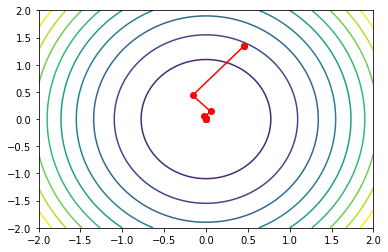

Minimum of 1.1171947239331634e-07 
found in 0.0007334999972954392 seconds 
and 10 steps.


,$x$ coord.,$y$ coord.
0,0.458853,1.351328
1,0.454260,1.344569
2,-0.160208,0.435845
3,0.055956,0.140550
4,-0.018460,0.047590
5,0.004540,0.016797
6,-0.002060,0.005472
7,0.000161,0.001220
8,-0.000816,-0.000051
9,-0.000406,-0.000342


In [131]:
import time
import pandas as pd

timer_start = time.perf_counter() # start of timer
converged, coord_hist, f_min = GradDescent(f, RandCoord(-2, 2, -2, 2))
timer_end = time.perf_counter() # end timer
time = timer_end - timer_start

x, y = np.meshgrid(nx, ny)
z = f(x, y)

fig = plt.figure()
levels = np.arange(np.min(z), np.max(z), 0.3)
plt.contour(x, y, z, levels=levels)
plt.plot(coord_hist[:,0], coord_hist[:,1], 'ro-')
plt.show()
print("Minimum of", f_min, "\nfound in", time, "seconds \nand", len(coord_hist), "steps.")
# print("Starting coordinates:", coord_hist[0])
# print("Ending coordinates:  ", coord_hist[-1])

col_name = {'$x$ coord.':coord_hist[:,0], '$y$ coord.':coord_hist[:,1]}
pd.DataFrame(col_name)